In [1]:
import magpylib

/home/javkt/anaconda3/lib/python3.9/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cuboid(id=124257888707248) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/home/javkt/anaconda3/lib/python3.9/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cuboid(id=124257888710032) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/home/javkt/anaconda3/lib/python3.9/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cuboid(id=124257888707200) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/home/javk

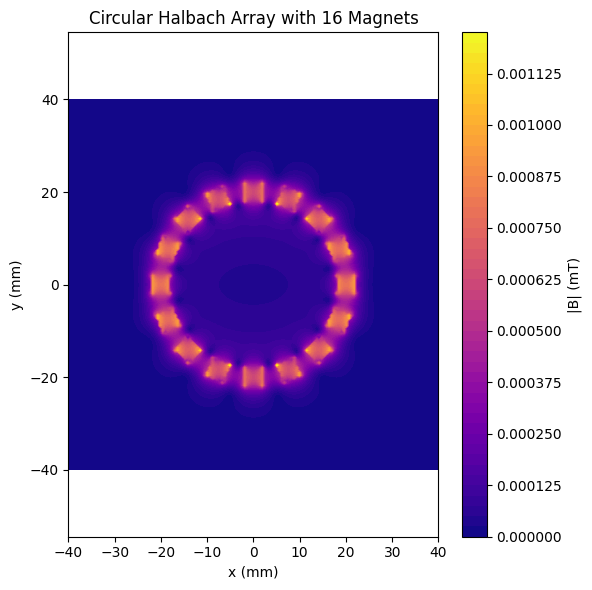

In [3]:
import magpylib as mag
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x = 16  # Number of magnets (change this to your desired number)
radius = 20  # Radius of the ring in mm
magnet_size = (4, 4, 10)  # Dimensions of each cuboid magnet in mm
mag_strength = 1000  # Magnetization strength (arbitrary units)

# Create the circular Halbach array
halbach_ring = mag.Collection()

for i in range(x):
    angle = 2 * np.pi * i / x  # Angle around the circle
    pos = [radius * np.cos(angle), radius * np.sin(angle), 0]

    # Magnetization direction - Halbach pattern
    # Enhances field inside the ring
    mag_angle = angle + np.pi / 2
    magnetization = [
        mag_strength * np.cos(mag_angle),
        mag_strength * np.sin(mag_angle),
        0
    ]
    
    # Create and rotate magnet
    magnet = mag.magnet.Cuboid(
        magnetization=magnetization,
        dimension=magnet_size
    )
    magnet.move(pos)
    magnet.rotate_from_angax(angle=np.degrees(angle), axis='z', anchor=pos)
    
    halbach_ring.add(magnet)

# Plot magnetic field in XY plane
grid_x, grid_y = np.meshgrid(np.linspace(-40, 40, 150), np.linspace(-40, 40, 150))
positions = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=-1)
B = halbach_ring.getB(positions)
B_mag = np.linalg.norm(B, axis=-1)

# Plot
plt.figure(figsize=(6,6))
plt.contourf(grid_x, grid_y, B_mag, levels=60, cmap='plasma')
plt.colorbar(label='|B| (mT)')
plt.title(f"Circular Halbach Array with {x} Magnets")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.axis("equal")
plt.tight_layout()
plt.show()
